# Multiperceptrón con TF - Autos - Predicción
---
**Montar la carpeta de Google Drive y definir constantes para trabajar**

In [4]:
# configuración para notebook con instalación LOCAL
FUENTES_DIR  = '../../Datos-Fuentes/Fuentes/'     # carpeta donde se encuentran archivos .py auxiliares
DATOS_DIR    = '../../Datos-Fuentes/Datos/'      # carpeta donde se encuentran los datasets
MODELOS_DIR  = '../Modelos/'    # carpeta donde se encuentran los modelos
ARCHIVOs_DIR = '../Archivos/'   # carpeta recuperar o copiar archivos

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

**Carga del Dataset y selección de atributos numéricos**

In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import chardet
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Input, LeakyReLU

nombre_archivo = DATOS_DIR + 'AUTOS.csv'

#-- detectando la codificación de caracteres usada ----
with open(nombre_archivo, 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

df= pd.read_csv(nombre_archivo, encoding=result['encoding'])
display(df)

#-- seleccionar los atributos numéricos --
df = df.select_dtypes(include = ["int16", "int32", "int64", "float16", "float32", "float64"])

,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,symboling
0,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0,3
1,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0,3
2,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,...,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0,1
3,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,...,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0,2
4,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,...,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,...,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28,16845.0,-1
201,95.0,volvo,gas,turbo,four,sedan,rwd,front,109.1,188.8,...,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25,19045.0,-1
202,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,...,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23,21485.0,-1
203,95.0,volvo,diesel,turbo,four,sedan,rwd,front,109.1,188.8,...,idi,3.01,3.40,23.0,106.0,4800.0,26,27,22470.0,-1


**Asignar atributos sin valor o con valor nulo**

In [6]:
# muestra cantidad de valores faltantes o nulos por atributo/característica
print(df.isnull().sum())


values = {'normalized-losses': df['normalized-losses'].mean(),
          'bore': df['bore'].mean(),
          'stroke': df['stroke'].mean(),
          'horsepower': df['horsepower'].mean(),
          'peak-rpm': df['peak-rpm'].mean(),
          'price': df['price'].mean()}

# reemplaza valores nulos por los indicados en el diccionario values
df = df.fillna(value=values)

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
symboling             0
dtype: int64


**Normalización de valores de atributos y valores a predecir**

In [7]:
# Imprime matriz de correclacion
#corr = df.corr()
#plt.figure()
#sns.heatmap(corr, square=True,  annot=True, linewidths=.5)

datos = np.array(df)
normalizarEntrada = 1

attPred = [12,14] #12 mpg-highway y 14 precio  #-- nro de atributos a predecir
T = datos[:, attPred]
X = np.delete(datos, attPred, 1) # elimina columnas de atributos a predecir

if normalizarEntrada:
    data_scaler, target_scaler = StandardScaler(), StandardScaler()
    X = data_scaler.fit_transform(X)
    T = target_scaler.fit_transform(T)

# %% Separa los datos y clase en grupo de entrenamiento y validacion
x_train, x_val, y_train, y_val = train_test_split(X, T, test_size = 0.2,  shuffle = True)

**Construccion del modelo**

In [8]:
6# cantidad de pasadas de los datos
EPOCAS = 1000
# cantidad de datos a procesar para actualizar pesos
TAM_LOTE = 64

ENTRADAS = X.shape[1]
SALIDAS = len(attPred)

ACTIVACION = LeakyReLU()
#ACTIVACION = 'ReLU'
#ACTIVACION = 'tanh'
#ACTIVACION = 'sigmoid'

#OPTIMIZADOR = 'sgd'
OPTIMIZADOR = 'rmsprop'
#OPTIMIZADOR = 'adam'
PACIENCIA = 15

model = Sequential()
model.add(Input(shape=(ENTRADAS,)))
model.add(Dense(6, activation=ACTIVACION))
model.add(Dense(3, activation= ACTIVACION))
model.add(Dense(SALIDAS))

model.summary()

# obtiene la arquitectura para el modelo y lo compila
model.compile(optimizer=OPTIMIZADOR, loss='mae', metrics = ['accuracy', 'mae', 'mse'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6)              │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119 (476.00 B)

 Trainable params: 119 (476.00 B)

 Non-trainable params: 0 (0.00 B)

**Entrenamiento del modelo con parada temprana**

In [9]:
# El parámetro patience indica la cantidad de epocas que deben transcurrir
# sin mejoras en el entrenamiento
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PACIENCIA)

# Entrena el modelo y guarda la historia del progreso
history = model.fit(x = x_train, y = y_train, batch_size = TAM_LOTE, epochs = EPOCAS,
              validation_data = (x_val, y_val), callbacks=[early_stop])

print('\n'+'-'*80)
print('Epocas utilizadas: %d' % len(history.epoch))

# %% Evalua e informa resultado de entrenamiento, validación y testeo
# evalua el modelo con los datos de entreanmiento
pred = model.evaluate(x_train, y_train, verbose=0)
print('\nEfectividad del modelo con datos de entrenamiento para:' )
print(" - Accuracy: %6.2f%%" % (pred[1]*100))
print(" - Pérdida : %9.5f" % (pred[0]))

# evalua el modelo con los datos de validacion
pred = model.evaluate(x_val, y_val, verbose=0)
print('\nEfectividad del modelo con datos de validacion para:' )
print(" - Accuracy: %6.2f%%" % (pred[1]*100))
print(" - Pérdida : %9.5f" % (pred[0]))


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.8254 - loss: 0.8098 - mae: 0.8098 - mse: 1.3267 - val_accuracy: 0.7805 - val_loss: 0.7869 - val_mae: 0.7869 - val_mse: 1.1610
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8109 - loss: 0.7566 - mae: 0.7566 - mse: 1.1055 - val_accuracy: 0.7805 - val_loss: 0.7636 - val_mae: 0.7636 - val_mse: 1.0741
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8081 - loss: 0.7669 - mae: 0.7669 - mse: 1.1809 - val_accuracy: 0.7805 - val_loss: 0.7449 - val_mae: 0.7449 - val_mse: 1.0115
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8552 - loss: 0.7342 - mae: 0.7342 - mse: 1.0535 - val_accuracy: 0.7805 - val_loss: 0.7288 - val_mae: 0.7288 - val_mse: 0.9593
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8493 - loss: 0.7324 - mae: 0.7324 - mse: 1.0568 - val_accuracy: 0.7805 - val_loss: 0.7154 - val_mae: 0.7154 - val_mse: 0.9143
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms

**Gráficos con evolución de curvas de error y accuracy**

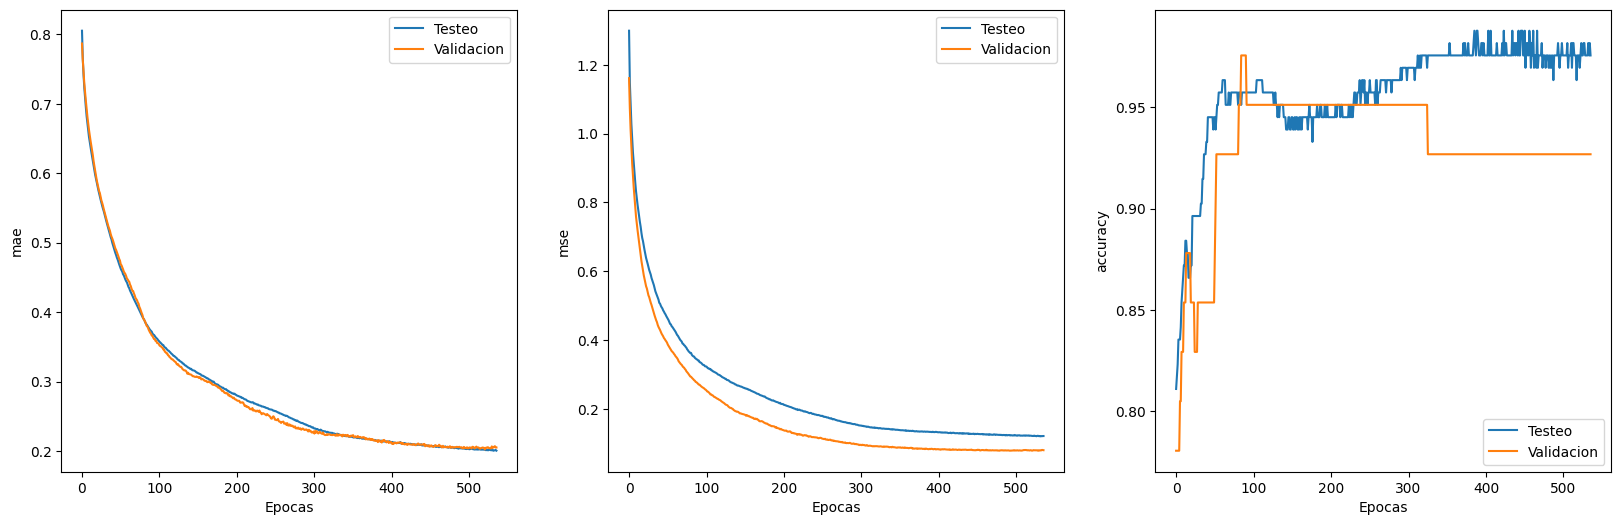

In [10]:
hist = history.history

def dibujar_curva(axs, value, epocas, hist):
    axs.plot(epocas, hist[value], label='Testeo')
    axs.plot(history.epoch, hist['val_'+value], label = 'Validacion')

    axs.set(xlabel="Epocas", ylabel=value)
    axs.legend()

fig, axs = plt.subplots(1,3, figsize=(20,6))

dibujar_curva(axs[0], 'mae', history.epoch, hist)
dibujar_curva(axs[1], 'mse', history.epoch, hist)
dibujar_curva(axs[2], 'accuracy', history.epoch, hist)

**Retroalimentación visual de las predicciones sobre los datos de validación**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[Text(0.5, 0, 'Ejemplo'), Text(0, 0.5, 'Precio del Vehículo')]

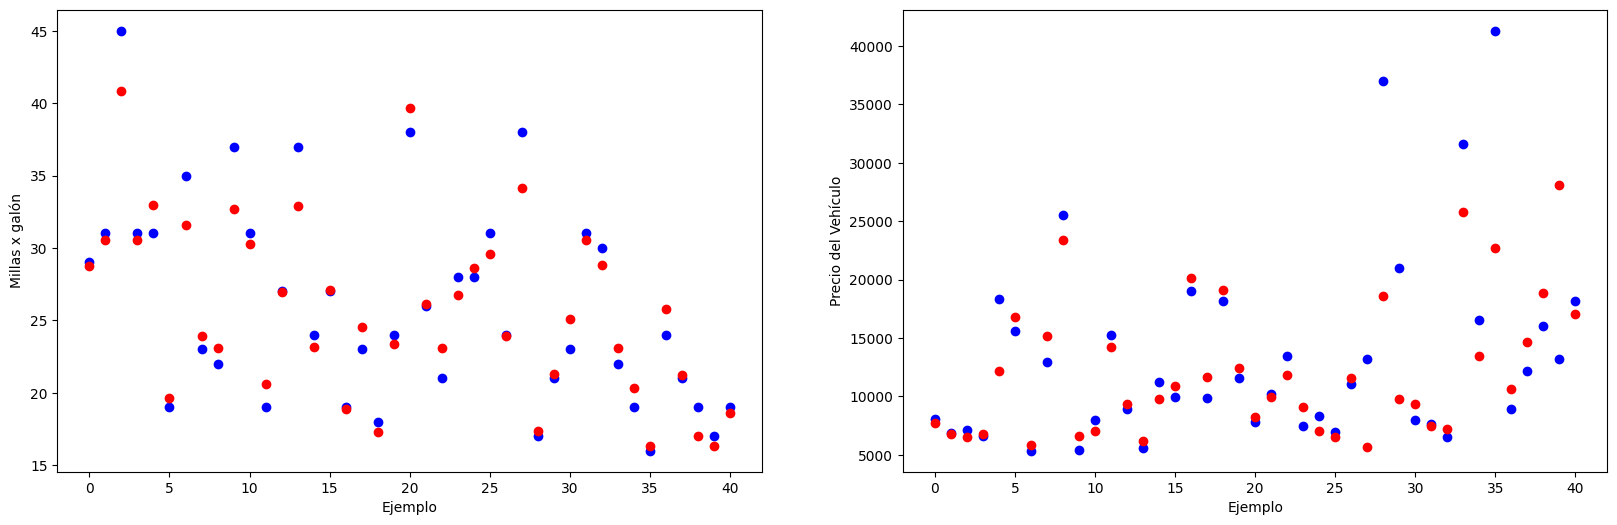

In [13]:
y_pred = model.predict(x_val)

y_val_no_norm = target_scaler.inverse_transform(y_val)
y_pred_no_norm = target_scaler.inverse_transform(y_pred)

fig, axs = plt.subplots(1,2, figsize=(20,6))

# lista con nro de iteracion
sample = list(range(len(y_val_no_norm)))

axs[0].plot(sample, y_val_no_norm[:,0],  "o", color='blue')
axs[0].plot(sample, y_pred_no_norm[:,0], "o", color='red')
axs[0].set(xlabel='Ejemplo', ylabel='Millas x galón')

axs[1].plot(sample, y_val_no_norm[:,1],  "o", color='blue')
axs[1].plot(sample, y_pred_no_norm[:,1], "o", color='red')
axs[1].set(xlabel='Ejemplo', ylabel='Precio del Vehículo')